In [1]:
import sys
sys.path.append('..')
from utils import d_sl, list_species, version, rio, np, plt, dense_vegetation, DATA_PATH
from utils import df as df_species
from os.path import exists
from produce_maps.tcrit import TCRIT, Tcrit_map, data_both_biomes
years = [str(i) for i in range(2001, 2023)]
import pandas as pd
from scipy import stats
from matplotlib import colormaps
import seaborn as sns
import cv2 as cv
from scipy.stats import skew
from matplotlib import colors
plt.rcParams.update({'font.size': 11})
terra = rio.open(DATA_PATH + "/terraaqua.tif", 'r').read(1)


Tmin = Tcrit_map

Tmin_2100 = rio.open(DATA_PATH + f"/outputs/Tcrit_map_min_2071_2100_ssp370{version}.tif", 'r').read(1)
Tmin_2100[Tmin_2100==1000] = np.nan
Tmin_2100[Tmin_2100==0] = np.nan
    

file_species = DATA_PATH + f'/outputs/species_above_threshold_1981_2010{version}.tif'
rio_species = rio.open(file_species, 'r')
data_allspecies = rio_species.read(1)
data_allspecies[dense_vegetation == 0] = 0
data_allspecies[~data_both_biomes] = 0
d_ext = {"South America": "south_america",  "Africa": "africa", "SE Asia": "south_east_asia"}
d_ext = {value: key for key, value in d_ext.items()}
d_color = {}
for i, j in zip(sns.color_palette("husl", 3), ["SE Asia", "South America", "Africa"]):
    d_color[j] = i

In [2]:
for key , ext in d_ext.items():
    if not exists(DATA_PATH + f"/outputs/datassp_{key}{version}.npy"):
        sl = d_sl[key]
        Tmap_file = DATA_PATH + f"/outputs/delta_Tmin_Tmodis{key}_per_year_2001_2020_reversed{version}.npy"
        Tmap = np.load(Tmap_file) + Tmin[sl][...,np.newaxis]
        Tmap = Tmap.astype(float)
        Tmap[~data_both_biomes[sl]] = np.nan
        Tmap2020 = Tmap[...,-1]
        Tmap = Tmap[...,0] # 2001

        filename_delta = DATA_PATH + f"/2050-2100_temperatures/delta_tsurf_2020_2100.tif"
        delta_tsurf = rio.open(filename_delta, 'r').read(1)[sl]
        delta_tsurf[delta_tsurf==-20] = np.nan
        delta_tsurf[dense_vegetation[sl]==0] = np.nan
        delta_tsurf[~data_both_biomes[sl]] = np.nan

        Tmap2100 = Tmap2020 + delta_tsurf


        data = np.load(DATA_PATH + f"/outputs/species_presences_{key}_covariates_1981_2010{version}.npy")
        data[~data_both_biomes[sl]] = False
        data[np.isnan(Tmap)] = False

        z_sum = np.sum(data, axis=(0,1))
        condition_species1 = np.where(z_sum!=0)[0]
        data = data[...,condition_species1]



        threshold_temps_ = []
        for sp in list_species:
            threshold_temps_.append(float(min(df_species[df_species['Plant species clean'] == sp]['Thermal Tolerance_deg.C'])))
        threshold_temps = [threshold_temps_[i] for i in condition_species1]
        print(np.mean(threshold_temps), np.mean(threshold_temps_)) # 50.89000000000001 50.6788

        condition_spatial1 = np.where(np.sum(data, axis=2) > 1) # at least 1 species
        data_ = data.copy()
        data_ = data_[condition_spatial1[0], condition_spatial1[1]]
        condition_spatial2 = np.where(np.sum(data_, axis=1) > 3) # at least 3 species 
        data_ = data_[condition_spatial2[0]]


        Tmap = Tmap[condition_spatial1[0], condition_spatial1[1]]
        Tmap = Tmap[condition_spatial2[0]]


        Tmap2020 = Tmap2020[condition_spatial1[0], condition_spatial1[1]]
        Tmap2020 = Tmap2020[condition_spatial2[0]]

        Tmap2100 = Tmap2100[condition_spatial1[0], condition_spatial1[1]]
        Tmap2100 = Tmap2100[condition_spatial2[0]]

        z_sum = np.sum(data_, axis=0)
        condition_species2 = np.where(z_sum!=0)[0]
        threshold_temps = [threshold_temps[i] for i in condition_species2]
        data_ = data_[...,condition_species2]


        ssp = '2071_2100_ssp370'
        datassp = np.load(DATA_PATH + f"/outputs/species_presences_{key}_covariates_{ssp}{version}.npy")
        print('ssp', datassp.shape)
        datassp[~data_both_biomes[sl]] = False
        datassp = datassp[...,condition_species1]
        datassp_ = datassp.copy()
        datassp_ = datassp_[condition_spatial1[0], condition_spatial1[1]]
        datassp_ = datassp_[condition_spatial2[0]]
        datassp_ = datassp_[...,condition_species2]
        np.save(DATA_PATH + f"/outputs/Tmap{key}{version}.npy", Tmap)
        np.save(DATA_PATH + f"/outputs/datassp_{key}{version}.npy", datassp_)
        np.save(DATA_PATH + f"/outputs/data_{key}{version}.npy", data_)

        np.save(DATA_PATH + f"/outputs/Tmap2020{key}{version}.npy", Tmap2020)
        np.save(DATA_PATH + f"/outputs/Tmap2100{key}{version}.npy", Tmap2100)
        np.save(DATA_PATH + f"/outputs/threshold_temps{key}{version}.npy", np.asarray(threshold_temps))

45.73354849214879 45.657041912687255
ssp (7104, 9122, 218)
46.27128580293512 45.657041912687255
ssp (4497, 7693, 218)
45.47860703292301 45.657041912687255
ssp (5018, 9999, 218)


In [3]:

def find_same_values_locations_vectorized(arr):
    # Reshape the array to 2D, collapsing the Z axis
    if len(arr.shape) == 3:
        reshaped_arr = arr.reshape(arr.shape[0]*arr.shape[1], arr.shape[2])
    elif len(arr.shape) == 2:
        reshaped_arr = arr
    else:
        raise NotImplementedError
    # Find unique rows along the collapsed axis
    unique_rows, inverse_indices, counts = np.unique(reshaped_arr, axis=0, return_inverse=True, return_counts=True)
    
    # Find rows that occur more than once
    duplicate_rows_mask = counts[inverse_indices] > 1
    
    # Get indices of duplicate rows
    duplicate_indices = np.where(duplicate_rows_mask)[0]
    
    # Convert indices to original positions (x, y)
    grouped_locations = {}
    if len(arr.shape) == 3:
        x_indices, y_indices = np.unravel_index(duplicate_indices, (arr.shape[0], arr.shape[1]))
        # Group the duplicate positions by their unique values
        for x, y in zip(x_indices, y_indices):
            value = tuple(arr[x, y, :])
            if value not in grouped_locations:
                grouped_locations[value] = []
            grouped_locations[value].append((x, y))
    elif len(arr.shape) == 2:
        for index in duplicate_indices:
            value = tuple(arr[index, :])
            if value not in grouped_locations:
                grouped_locations[value] = []
            grouped_locations[value].append((index))
    
    return grouped_locations
# grouped_locations = find_same_values_locations_vectorized(data_) 
# key: [bools] representeing which species is present. 
# values: locations where these species are present


60
1000
2000
310182
30
102


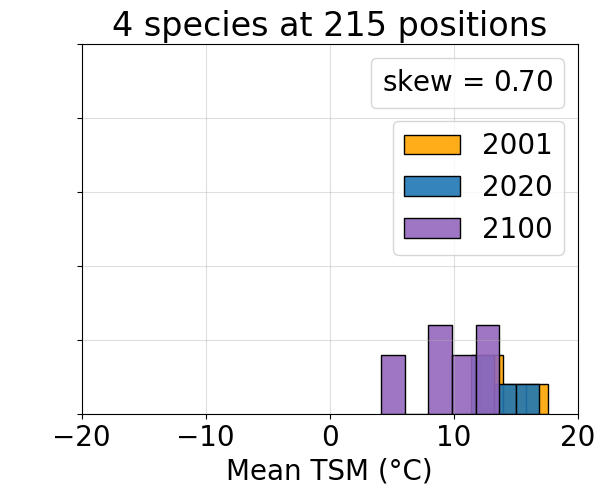

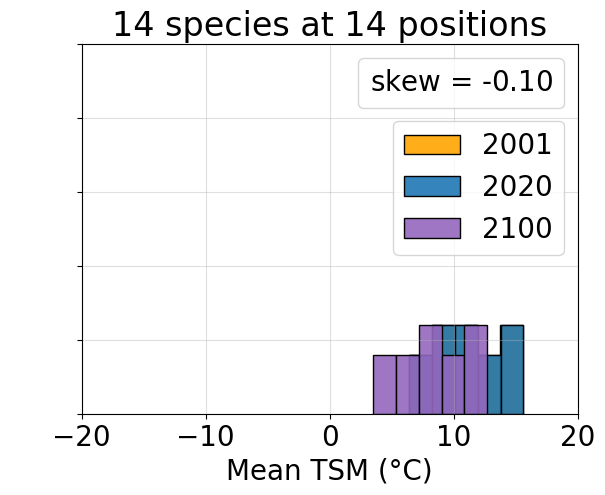

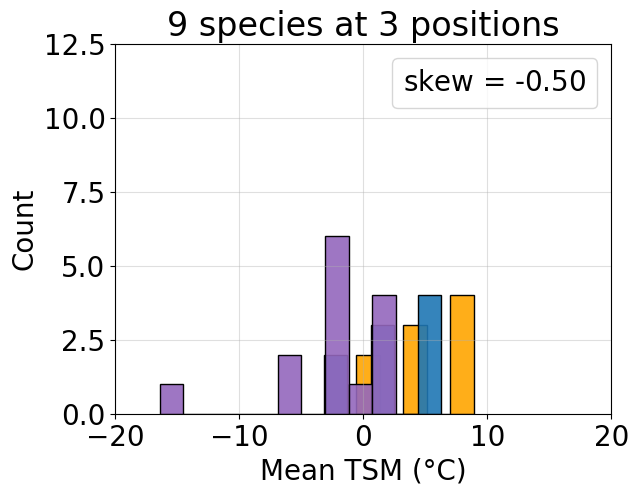

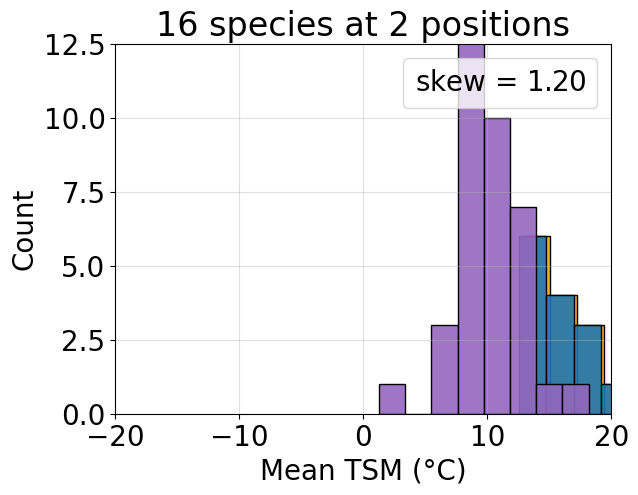

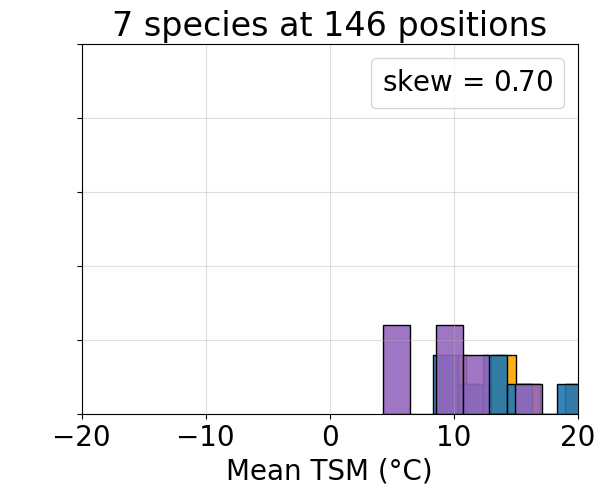

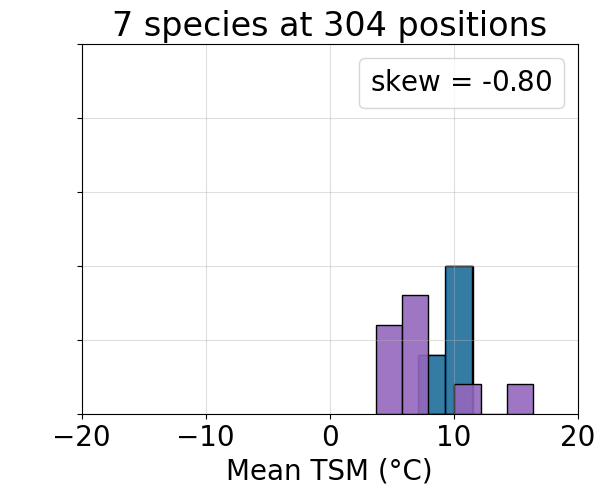

In [4]:
d_indexes = {
    'south_east_asia':[60,1000],
    'south_america':[2000, 310182],
    'africa': [30, 102]
}
for key, indexes in d_indexes.items():
    datassp_ = np.load(DATA_PATH + f"/outputs/datassp_{key}{version}.npy")
    data_ = np.load(DATA_PATH + f"/outputs/data_{key}{version}.npy")
    grouped_locations = find_same_values_locations_vectorized(data_)
    Tmap2020 = np.load(DATA_PATH + f"/outputs/Tmap2020{key}{version}.npy")
    Tmap2100 = np.load(DATA_PATH + f"/outputs/Tmap2100{key}{version}.npy")
    Tmap = np.load(DATA_PATH + f"/outputs/Tmap{key}{version}.npy")
    threshold_temps = np.load(DATA_PATH + f"/outputs/threshold_temps{key}{version}.npy")
    plt.rcParams.update({'font.size': 20})
    for index in indexes: #2, 202 0,12#np.random.randint(0, len(grouped_locations), size=(5)):
        print(index)
        key_group = list(grouped_locations.keys())[index] # [bools] representeing which species is present in 2020
        similar_locations = grouped_locations[key_group] # values: locations where these species are present in 2020
        plt.figure()
        t_observed = [Tmap[i] for i in similar_locations]
        t_observed2020 = [Tmap2020[i] for i in similar_locations] 
        t_observed2100 = [Tmap2100[i] for i in similar_locations] 
        
        present_species = np.where(key_group) # indexes of the present species in threshold_temps
        tcrits = [threshold_temps[i] for i in present_species[0]]
        d_tcrit = {i: [i-j for j in t_observed] for i in tcrits}
        d_tcrit_mean = {i:np.mean(j) for (i, j) in d_tcrit.items()}
        d_tcrit_median = {i:np.median(j) for (i, j) in d_tcrit.items()}
        d_tcrit2020 = {i: [i-j for j in t_observed2020] for i in tcrits}
        # d_tcrit2100 = {i: [i-j for j in t_observed2100] for i in tcrits}
        tcrits2100 = [[threshold_temps[j] for j in np.where(datassp_[i])[0]] for i in similar_locations] 
        tcritspresent2100 = {i:[j for j in range(len(tcrits2100)) if i in tcrits2100[j]] for i in np.unique(np.concatenate(tcrits2100))}
        d_tcrit2100ssp370 = {i: [i-j for c, j in enumerate(t_observed2100) if c in tcritspresent2100[i]] for i in tcritspresent2100.keys()}
        del tcritspresent2100
        
        
        d_tcrit_mean2020 = {i:np.mean(j) for (i, j) in d_tcrit2020.items()}
        # d_tcrit_mean2100 = {i:np.mean(j) for (i, j) in d_tcrit2100.items()}
        d_tcrit_mean2100ssp370 = {i:np.mean(j) for (i, j) in d_tcrit2100ssp370.items()}
        # d_tcrit_median2020 = {i:np.median(j) for (i, j) in d_tcrit2020.items()}
        binwidth = 2
        sns.histplot(x=d_tcrit_mean, stat='count', label='2001', color='orange', alpha=0.9, binwidth=binwidth)
        sns.histplot(x=d_tcrit_mean2020, stat='count', label='2020', color='tab:blue', alpha=0.9, binwidth=binwidth)
        sns.histplot(x=d_tcrit_mean2100ssp370, stat='count', label='2100', color='tab:purple', alpha=0.9, binwidth=binwidth)
        plt.xlabel(f'Mean TSM (°C)')
        plt.title(f"{len(tcrits)} species at {len(t_observed)} positions") #  in {key.replace('SE', 'Southeast')}
        plt.xlim(-20, 20)
        plt.ylim(0,12.5)
        # plt.ylim(0,0.25)
        first_legend = plt.legend(loc='upper right', bbox_to_anchor=(1, 0.83)) # 88
        dummy_line = plt.Line2D([], [], color='none', label=r"$\mathrm{skew}$"+f" = {np.round(skew(tcrits, nan_policy='omit'),1):.2f}")

        # Adding the second legend
        second_legend = plt.legend(handles=[dummy_line], loc='upper right',
                            handlelength=0, handletextpad=0, frameon=True)
        if key == "south_east_asia":
            plt.gca().add_artist(first_legend)
        if key != "south_america":
            plt.gca().yaxis.set_tick_params(labelcolor='none')
            plt.ylabel('')
        # Adding the first legend back to the plot
        # plt.gca().add_artist(second_legend)
        plt.grid(alpha=0.4)

In [5]:
# Just to test 
key = 'africa'
datassp_ = np.load(DATA_PATH + f"outputs/datassp_{key}{version}.npy")
data_ = np.load(DATA_PATH + f"outputs/data_{key}{version}.npy")
grouped_locations = find_same_values_locations_vectorized(data_)
Tmap2020 = np.load(DATA_PATH + f"outputs/Tmap2020{key}{version}.npy")
Tmap2100 = np.load(DATA_PATH + f"outputs/Tmap2100{key}{version}.npy")
Tmap = np.load(DATA_PATH + f"outputs/Tmap{key}{version}.npy")
threshold_temps = np.load(DATA_PATH + f"outputs/threshold_temps{key}{version}.npy")
plt.rcParams.update({'font.size': 20})

[53.618001241091626, 45.9, 42.2, 44.55, 41.58, 49.2, 45.6] [41.58       42.2        44.55       45.18       45.6        45.9
 48.6        49.2        53.61800124]
{53.618001241091626: 20.35430357978323, 45.9: 12.636302338691607, 42.2: 8.936302338691611, 44.55: 11.286302338691605, 41.58: 8.316302338691607, 49.2: 15.93630233869161, 45.6: 12.33630233869161} {41.58: 5.056255097258581, 42.2: 5.6762550972585855, 44.55: 9.07082263946533, 45.18: 4.335040187835695, 45.6: 9.076255097258585, 45.9: 9.311860193175239, 48.6: 11.49879256520953, 49.2: 12.676255097258585, 53.618001241091626: 17.094256338350206}


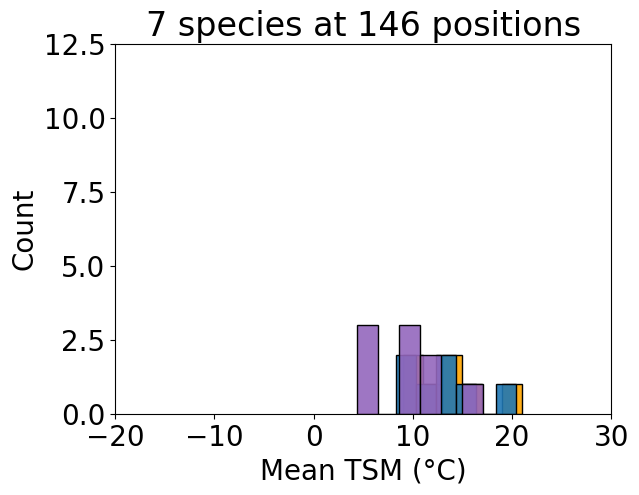

In [6]:
# Just to test 
for index in [30]:
    key_group = list(grouped_locations.keys())[index] # [bools] representeing which species is present in 2020
    similar_locations = grouped_locations[key_group] # values: locations where these species are present in 2020
    t_observed = [Tmap[i] for i in similar_locations]
    t_observed2020 = [Tmap2020[i] for i in similar_locations] 
    t_observed2100 = [Tmap2100[i] for i in similar_locations] 
    
    present_species = np.where(key_group) # indexes of the present species in threshold_temps
    tcrits = [threshold_temps[i] for i in present_species[0]]
    d_tcrit = {i: [i-j for j in t_observed] for i in tcrits}
    d_tcrit_mean = {i:np.mean(j) for (i, j) in d_tcrit.items()}
    d_tcrit_median = {i:np.median(j) for (i, j) in d_tcrit.items()}
    d_tcrit2020 = {i: [i-j for j in t_observed2020] for i in tcrits}
    # d_tcrit2100 = {i: [i-j for j in t_observed2100] for i in tcrits}
    tcrits2100 = [[threshold_temps[j] for j in np.where(datassp_[i])[0]] for i in similar_locations] 
    tcritspresent2100 = {i:[j for j in range(len(tcrits2100)) if i in tcrits2100[j]] for i in np.unique(np.concatenate(tcrits2100))}
    d_tcrit2100ssp370 = {i: [i-j for c, j in enumerate(t_observed2100) if c in tcritspresent2100[i]] for i in tcritspresent2100.keys()}
    d_tcrit_mean2020 = {i:np.mean(j) for (i, j) in d_tcrit2020.items()}
    # d_tcrit_mean2100 = {i:np.mean(j) for (i, j) in d_tcrit2100.items()}
    d_tcrit_mean2100ssp370 = {i:np.mean(j) for (i, j) in d_tcrit2100ssp370.items()}
    print(tcrits, np.unique(np.concatenate(tcrits2100)))
    print(d_tcrit_mean2020, d_tcrit_mean2100ssp370)
    binwidth = 2
    sns.histplot(x=d_tcrit_mean, stat='count', label='2001', color='orange', alpha=0.9, binwidth=binwidth)
    sns.histplot(x=d_tcrit_mean2020, stat='count', label='2020', color='tab:blue', alpha=0.9, binwidth=binwidth)
    sns.histplot(x=d_tcrit_mean2100ssp370, stat='count', label='2100', color='tab:purple', alpha=0.9, binwidth=binwidth)
    plt.xlabel(f'Mean TSM (°C)')
    plt.title(f"{len(tcrits)} species at {len(t_observed)} positions") #  in {key.replace('SE', 'Southeast')}
    plt.xlim(-20, 30)
    plt.ylim(0,12.5)

# Map to know where are the histograms from

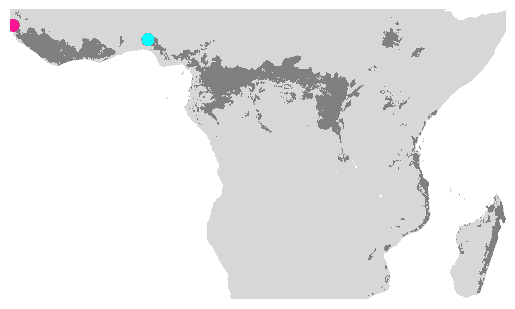

In [7]:
# Africa
sl = d_sl[key]
Tmap_file = DATA_PATH + f"/outputs/delta_Tmin_Tmodis{key}_per_year_2001_2020_reversed{version}.npy"
Tmap = np.load(Tmap_file) + Tmin[sl][...,np.newaxis]
Tmap = Tmap.astype(float)
Tmap[~data_both_biomes[sl]] = np.nan
Tmap = Tmap[...,0] # 2001



data = np.load(DATA_PATH + f"/outputs/species_presences_{key}_covariates_1981_2010{version}.npy")
data[~data_both_biomes[sl]] = False
data[np.isnan(Tmap)] = False

z_sum = np.sum(data, axis=(0,1))
condition_species1 = np.where(z_sum!=0)[0]
data = data[...,condition_species1]

condition_spatial1 = np.where(np.sum(data, axis=2) > 1) # at least 1 species
data_ = data.copy()
data_ = data_[condition_spatial1[0], condition_spatial1[1]]
condition_spatial2 = np.where(np.sum(data_, axis=1) > 3) # at least 3 species 
data_ = data_[condition_spatial2[0]]

z_sum = np.sum(data_, axis=0)
condition_species2 = np.where(z_sum!=0)[0]


Tmap = np.load(DATA_PATH + f"/outputs/Tmap{key}{version}.npy")
final_map = np.zeros(terra[sl].shape, dtype=bool)

fig = plt.figure()
ax = fig.gca()

for (index, col, bg) in zip([30, 102], ['deeppink', 'cyan'], ['grey', '#00000000']):
    key_group = list(grouped_locations.keys())[index] 
    similar_locations = grouped_locations[key_group]
    present_species = np.where(key_group)
    tcrits = [threshold_temps[i] for i in present_species[0]]
    t_observed = [Tmap[i] for i in similar_locations]
    t_observed2020 = [Tmap2020[i] for i in similar_locations] 

    d_tcrit = {i: [i-j for j in t_observed] for i in tcrits}
    d_tcrit_mean = {i:np.mean(j) for (i, j) in d_tcrit.items()}
    d_tcrit_median = {i:np.median(j) for (i, j) in d_tcrit.items()}


    d_tcrit2020 = {i: [i-j for j in t_observed2020] for i in tcrits}
    d_tcrit_mean2020 = {i:np.mean(j) for (i, j) in d_tcrit2020.items()}
    d_tcrit_median2020 = {i:np.median(j) for (i, j) in d_tcrit2020.items()}



    h_coords, w_coords = np.meshgrid(np.arange(Tmin[sl].shape[0]), np.arange(Tmin[sl].shape[1]), indexing='ij')
    coords_array = np.stack((h_coords, w_coords), axis=-1)
    observed_coords_array = coords_array[condition_spatial1[0], condition_spatial1[1]]
    observed_coords_array = observed_coords_array[condition_spatial2[0]]
    observed_coords_array = [observed_coords_array[i] for i in similar_locations][:1] 

    species_map = np.zeros(coords_array[..., 0].shape, dtype=bool)
    coords = (np.asarray([i[0] for i in observed_coords_array]), np.asarray([i[1] for i in observed_coords_array]))
    species_map[coords[0], coords[1]] = True


    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (200, 200)) 
    dilation = cv.dilate(species_map.astype(np.uint8), kernel, iterations=1)
    final_map[dilation != 0] = 1
    cols = [bg, col]
    cmap_species = colors.ListedColormap(cols)
    cmap_species.set_bad(alpha=0)
    terra_masked_ = terra.copy()
    im = ax.imshow(dilation, cmap=cmap_species)


constraint = ((dense_vegetation==1) * (data_allspecies!=0))[sl].squeeze() 
terra_masked__ = terra_masked_.copy()
terra_masked__ = terra_masked__[sl].squeeze()
terra_masked__[constraint] = 2
terra_masked__[(~data_both_biomes[sl]) * (terra_masked__ != 0)] = 1
terra_masked__[(final_map == True)] = 3
cmap_terra = colors.ListedColormap(['white', '#D7D7D7FF', 'grey', '#00000000'])
ax.imshow(terra_masked__, cmap=cmap_terra)
ax.set_axis_off()